In [1]:
"""Mainly Edited for private usage by:  Ioanna Mitsioni
                                        Ioannis Agriomallos
License: BSD 3 clause
"""
import time
start_time = time.time()
from copy import deepcopy, copy
import math
import scipy.io as sio
import shutil
import os
from random import shuffle
import numpy as np
from pylab import *
# from featext2 import *
import matplotlib.pyplot as plt
%matplotlib inline 
#matplotlib qt
# inline (suitable for ipython only, shown inside browser!) or qt (suitable in general, shown in external window!)
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D #, axes3d
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from collections import OrderedDict
import re
import datetime
import urllib
import tarfile
# import joblib
# from joblib import Parallel, delayed, Memory
from tempfile import mkdtemp
import copy_reg
import types
import itertools
from itertools import compress
from collections import Counter
import glob

#import multiprocessing
def _pickle_method(m):
    if m.im_self is None:
        return getattr, (m.im_class, m.im_func.func_name)
    else:
        return getattr, (m.im_self, m.im_func.func_name)
copy_reg.pickle(types.MethodType, _pickle_method)


h = .2  # step size in the mesh
window = 1024

In [2]:
############ Feature Names ############
"""features:                                                                       ||      if       
   |--> time domain      :                                                         || samples = 1024
   |----|---> phinyomark : 11+3{shist} --------------------------> = 14+0.0samples ||             14
   |----|---> golz       : 10+samples{acrol} --------------------> = 10+1.0samples ||           1034
   |--> frequency domain :                                                                          
   |----|---> phinyomark : 3{arco}+4{mf}+2(samples/2+1){RF,IF} --> =  9+1.0samples ||           1033
   |----|---> golz       : 2(samples/2+1){AF,PF} ----------------> =  2+1.0samples ||           1026
   |----|----------------|-------alltogether---------------------> = 35+3.0samples || numfeat = 3107
"""
## Time Domain Phinyomark feats
featnames = ['intsgnl', 'meanabs', 'meanabsslp', 'ssi', 'var', 'rms', 'rng', 'wavl', 'zerox', 'ssc', 'wamp', 
             'shist1', 'shist2', 'shist3']                                                   # 11+3{shist}
## Frequency Domain Phinyomark feats
featnames += ['arco1', 'arco2', 'arco3', 'mnf', 'mdf', 'mmnf', 'mmdf']                       # 3{arco}+4{mf}
featnames += ['reFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{RF}
featnames += ['imFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{IF}
## Time Domain Golz feats
featnames += ['meanv', 'stdr', 'mx', 'rngx', 'rngy', 'med', 'hjorth', 'sentr', 'se', 'ssk']  # 10
featnames += ['acrol{:04d}'.format(i) for i in range(window)]                                # samples{acrol}
## Frequency Domain Golz feats
featnames += ['amFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{AF}
featnames += ['phFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{PF}

In [3]:
############ Prepare the indeces for each feature ############
def get_feat_id(feat_ind, printit=0, sample_window=window): 
    """Find the corresponding indeces of the desired features inside feature vector,
    and link them with their names and level of abstraction
    -> feat_ind        : range of indeces
    -> printit         : print output indeces (1) or not (0)
    -> sample_window   : parameter for accurate computation of feature indeces
    <- full_path_id    : indeces of all features
    <- norm_time_feats : indeces of time features
    <- norm_freq_feats : indeces of frequency features
    """
    # get the feat inds wrt their source : 3rd level
    norm_time_phin = range(0,14)
    norm_freq_phin = range(norm_time_phin[-1] + 1, norm_time_phin[-1] + 9 + sample_window + 1)
    norm_time_golz = range(norm_freq_phin[-1] + 1, norm_freq_phin[-1] + 10 + sample_window + 1)
    norm_freq_golz = range(norm_time_golz[-1] + 1, norm_time_golz[-1] + 2 + sample_window + 1)
    # get the feat inds wrt their domain : 2nd level 
    norm_time_feats = norm_time_phin + norm_time_golz
    norm_freq_feats = norm_freq_phin + norm_freq_golz
    # get the feat inds wrt their prefeat: 1st level 
    norm_feats = norm_time_feats + norm_freq_feats

    # get the feat inds wrt their source : 3rd level
    disp = norm_feats[-1]+1
    ftfn_time_phin = range(disp ,disp + 14)
    ftfn_freq_phin = range(ftfn_time_phin[-1] + 1, ftfn_time_phin[-1] + 9 + sample_window + 1)
    ftfn_time_golz = range(ftfn_freq_phin[-1] + 1, ftfn_freq_phin[-1] + 10 + sample_window + 1)
    ftfn_freq_golz = range(ftfn_time_golz[-1] + 1, ftfn_time_golz[-1] + 2 + sample_window + 1)
    # get the feat inds wrt their domain : 2nd level 
    ftfn_time_feats = ftfn_time_phin + ftfn_time_golz
    ftfn_freq_feats = ftfn_freq_phin + ftfn_freq_golz
    # get the feat inds wrt their prefeat: 1st level 
    ftfn_feats = ftfn_time_feats + ftfn_freq_feats

    # create the final "reference dictionary"
    # 3 np.arrays, id_list[0] = level 1 etc
    id_list = [np.zeros((len(ftfn_feats + norm_feats),1)) for i in range(3)]
    id_list[0][:norm_feats[-1]+1] = 0 # 0 signifies norm / 1 signifies ft/fn
    id_list[0][norm_feats[-1]+1:] = 1

    id_list[1][:norm_time_phin[-1]+1] = 0 # 0 signifies time / 1 signifies freq
    id_list[1][norm_time_phin[-1]+1:norm_freq_phin[-1]+1] = 1
    id_list[1][norm_freq_phin[-1]+1:norm_time_golz[-1]+1] = 0
    id_list[1][norm_time_golz[-1]+1:norm_freq_golz[-1]+1] = 1
    id_list[1][norm_freq_golz[-1]+1:ftfn_time_phin[-1]+1] = 0
    id_list[1][ftfn_time_phin[-1]+1:ftfn_freq_phin[-1]+1] = 1
    id_list[1][ftfn_freq_phin[-1]+1:ftfn_time_golz[-1]+1] = 0
    id_list[1][ftfn_time_golz[-1]+1:] = 1

    id_list[2][:norm_freq_phin[-1]+1] = 0 #0 signifies phinyomark / 1 signifies golz
    id_list[2][norm_freq_phin[-1]+1:norm_freq_golz[-1]+1] = 1
    id_list[2][norm_freq_golz[-1]+1:ftfn_freq_phin[-1]+1] = 0
    id_list[2][ftfn_freq_phin[-1]+1:] = 1 
    
    full_path_id = [np.zeros((len(feat_ind),5)) for i in range(len(feat_ind))]
   
    for ind, val in enumerate(feat_ind):
        full_path_id[ind] = [val, id_list[2][val], id_list[1][val], id_list[0][val]]
        if (printit==1):
            if(full_path_id[ind][1]==0):
                lvl3 = 'Phin'
            else:
                lvl3 = 'Golz'
            if(full_path_id[ind][2]==0):
                lvl2 = 'Time'
            else:
                lvl2 = 'Freq'
            if(full_path_id[ind][3]==0):
                lvl1 = 'Norm'
            else:
                lvl1 = 'Ft/Fn'
            print(feat_ind[ind],featnames[val%(norm_feats[-1]+1)],lvl3,lvl2,lvl1)
    
    return(full_path_id,norm_time_feats,norm_freq_feats)        

In [4]:
def subfeat_inds(ofs=len(featnames)):
    """returns a subfeatures' indeces
    -> ofs                     : number of features in total
    <- amfft, freq, time, both : split featureset indeces for 
                                 amplitude of FFT, all time only,
                                 all frequency only and all features
    """
    _,time,freq = get_feat_id(range(ofs))
    both = range(ofs)
    amfft = []
    for i in range(len(featnames)):
        if (featnames[i].startswith('amFFT')):
            amfft.append(i)
    return amfft, freq, time, both

In [5]:
def get_tot_feats(fs, subfs, r):
     ###############################################################################################################
    # Version 2, using the bool masks and keeping an array of 6x3000 feats 
    ###############################################################################################################
    # If checking for FnormAll, you end up with 36 models of (trained_on, tested_on) combinations but TECHNICALLY
    # the features are the same for every trained_on "sixplet" so there's no need to iterate over all the tested_on
    # indeces. Therefore, ts = 2 is chosen arbitrarily 
    
    filenames = glob.glob("data/results" + str(r) + "/fs_" + str(fs) + "_subfs_" + str(subfs) + "_*.npz")
    # the features kept for surface i will be stored in bool_tot_feats[i] (final size: 6x1000)
    bool_tot_feats = []
    best_tot_feats = []
    best_tot_scores = []
    
    for filn in filenames:
        # for every training surface     
        model_file = np.load(filn)
        model = model_file['model']
        #keep a list of the 1000 features kept
        model_feat_scores = model[0].named_steps['feature_selection'].scores_
        bool_model_features = list(model[0].named_steps['feature_selection'].get_support(indices = False))
        if subfs<=2:
            bool_model_features = np.logical_not(np.array(bool_model_features))
            bool_model_features[np.array(model_feat_scores).argsort()[-1000:][::-1].tolist()] = True
            bool_model_features = bool_model_features.tolist()
#         plt.plot(model_feat_scores)
        bool_tot_feats.append(bool_model_features)
        best_tot_scores.append(np.array(model_feat_scores[np.array(model_feat_scores).argsort()[-1000:][::-1].tolist()]))
        best_tot_feats.append(np.array(model_feat_scores).argsort()[-1000:][::-1])
        
    return bool_tot_feats, best_tot_feats, best_tot_scores

In [ ]:
def get_tot_feats_importance_pca(fs, subfs, r):
     ###############################################################################################################
    # Version 2, using the bool masks and keeping an array of 6x3000 feats 
    ###############################################################################################################
    # If checking for FnormAll, you end up with 36 models of (trained_on, tested_on) combinations but TECHNICALLY
    # the features are the same for every trained_on "sixplet" so there's no need to iterate over all the tested_on
    # indeces. Therefore, ts = 2 is chosen arbitrarily 
    
    filenames = glob.glob("data/results" + str(r) + "/fs_" + str(fs) + "_subfs_" + str(subfs) + "_*.npz")
    # the features kept for surface i will be stored in bool_tot_feats[i] (final size: 6x1000)
    bool_tot_feats = []
    best_tot_feats = []
    best_tot_scores = []
    
    for filn in filenames:
        # for every training surface     
        model_file = np.load(filn)
        model = model_file['model'][0]
        #keep a list of the 1000 features kept
        
        model_pca_var = model[0].named_steps['decomp'].explained_variance_
        model_pca_var_rat = model[0].named_steps['decomp'].explained_variance_ratio_
        model_pca_covar = model[0].named_steps['decomp'].get_covariance()
        model_pca_mean = model[0].named_steps['decomp'].mean_
        n_comp = model[0].named_steps['decomp'].n_components_
        comp = model[0].named_steps['decomp'].components_
        print len(model_pca_var), model_pca_var
        print len(model_pca_var_rat), model_pca_var_rat
        print model_pca_covar.shape, model_pca_covar
        # plt.imshow(model_pca_covar)
        print len(model_pca_mean), model_pca_mean
        print n_comp
        print comp.shape, comp
        nfeat = 1000
        feat_importance = np.zeros(nfeat)
        for nc in range(len(comp)):
            feat_importance += comp[nc]*model_pca_var_rat[nc]
        #     plt.plot(range(1000),comp[nc]*model_pca_var_rat[nc])
        plt.plot(range(nfeat),feat_importance/nfeat)
        print feat_importance*nfeat
        sort_feat_imp_ind = np.array(feat_importance).argsort()[:][::-1]
        print np.array(featnames)[sort_feat_imp_ind]
        
        
        model_feat_scores = model[0].named_steps['feature_selection'].scores_
        bool_model_features = list(model[0].named_steps['feature_selection'].get_support(indices = False))
        if subfs<=2:
            bool_model_features = np.logical_not(np.array(bool_model_features))
            bool_model_features[np.array(model_feat_scores).argsort()[-1000:][::-1].tolist()] = True
            bool_model_features = bool_model_features.tolist()
#         plt.plot(model_feat_scores)
        bool_tot_feats.append(bool_model_features)
        best_tot_scores.append(np.array(model_feat_scores[np.array(model_feat_scores).argsort()[-1000:][::-1].tolist()]))
        best_tot_feats.append(np.array(model_feat_scores).argsort()[-1000:][::-1])
        
    return bool_tot_feats, best_tot_feats, best_tot_scores

In [6]:
def freq_time_counter(full_names, subfs):
    f_c = 0; t_c = 0
    for i in range(len(full_names)):
        if full_names[i][2] == 1:
            if subfs!=2:
                f_c += 1
        else:
            if subfs>=2:
                t_c += 1
    return (f_c, t_c)

In [7]:
def get_common_feats(bool_tot_feats, subfs, skip_surf = 6, print_common_feats = 0):   
    # skip_surf = 6 by default so you won't skip any surfaces.
    # returns the list of inds for the common feats
    trans_test_bools = []

    for i in range(len(bool_tot_feats)):
        if i != skip_surf:
            trans_test_bools.append(bool_tot_feats[i])
        else: 
            continue
            
    trans_test_bools = np.transpose(trans_test_bools)
    common_feats = []
    matches  =[]
    for i in range(len(trans_test_bools)):
        matches.append(np.all(trans_test_bools[i]))
    for ind, val in enumerate(matches):
        if val:
            common_feats.append(ind)
    print("===============================================================")       
    print("%d common feats, out of %d total" %(len(common_feats),len(matches)))
    full_names, _, _ = get_feat_id(common_feats, printit = print_common_feats)
    freq_counter, time_counter = freq_time_counter(full_names, subfs)
    print("of which, %d (%.2f%%) were Freq features and %d (%.2f%%) were Time features" %(freq_counter, (float(freq_counter)/len(common_feats))*100, time_counter, (float(time_counter)/len(common_feats))*100 ))

    print("===============================================================")
    
    return common_feats, full_names

In [8]:
### Example 

subfs=3
for r in range(1,6):
    tot_feats, best_tot_feats, best_tot_scores = get_tot_feats(fs=0, subfs=subfs, r=r)
    common_feats, full_names = get_common_feats(bool_tot_feats=tot_feats, subfs=subfs, skip_surf=6, print_common_feats=0)
    fn = np.array(full_names)
    tmp = fn[:,0].astype(int).tolist()
#     print np.array(featnames)[tmp]
    for j in range(0,len(best_tot_feats),1):
        tmpj = best_tot_feats[j][:5]
#         print len(tmpj)
#         print j, best_tot_scores[j][:10]
        print j, np.array(featnames)[tmpj]

133 common feats, out of 3107 total
of which, 40 (30.08%) were Freq features and 93 (69.92%) were Time features
0 ['reFFT005' 'reFFT006' 'reFFT009' 'mmdf' 'rngy']
1 ['mmdf' 'reFFT006' 'reFFT003' 'reFFT008' 'reFFT009']
2 ['reFFT006' 'reFFT007' 'reFFT005' 'reFFT008' 'reFFT009']
3 ['reFFT006' 'reFFT007' 'reFFT005' 'reFFT008' 'reFFT009']
4 ['reFFT005' 'reFFT002' 'reFFT004' 'reFFT006' 'reFFT007']
5 ['reFFT005' 'reFFT006' 'reFFT009' 'mmdf' 'rngy']
6 ['rng' 'rngy' 'stdr' 'reFFT006' 'amFFT009']
7 ['reFFT006' 'reFFT007' 'reFFT005' 'reFFT008' 'reFFT009']
8 ['reFFT007' 'reFFT006' 'rng' 'rngy' 'reFFT003']
9 ['reFFT005' 'reFFT002' 'reFFT004' 'reFFT006' 'reFFT007']
10 ['reFFT007' 'reFFT006' 'rng' 'rngy' 'reFFT003']
11 ['rng' 'rngy' 'stdr' 'reFFT006' 'amFFT009']
12 ['reFFT005' 'reFFT006' 'reFFT009' 'mmdf' 'rngy']
13 ['rng' 'rngy' 'stdr' 'reFFT006' 'amFFT009']
14 ['reFFT005' 'reFFT006' 'reFFT009' 'mmdf' 'rngy']
15 ['mmdf' 'reFFT006' 'reFFT008' 'reFFT007' 'reFFT003']
16 ['reFFT005' 'reFFT002' 'reFFT004

281 common feats, out of 3107 total
of which, 265 (94.31%) were Freq features and 16 (5.69%) were Time features
0 ['reFFT007' 'reFFT006' 'reFFT005' 'reFFT009' 'rngy']
1 ['reFFT006' 'reFFT007' 'reFFT005' 'reFFT003' 'reFFT002']
2 ['reFFT006' 'reFFT008' 'rngy' 'rng' 'reFFT007']
3 ['reFFT006' 'reFFT007' 'rngy' 'rng' 'reFFT009']
4 ['reFFT006' 'reFFT007' 'rng' 'rngy' 'reFFT005']
5 ['reFFT006' 'reFFT007' 'rngy' 'rng' 'reFFT009']
6 ['reFFT006' 'reFFT008' 'rngy' 'rng' 'reFFT007']
7 ['reFFT006' 'reFFT007' 'reFFT005' 'rng' 'rngy']
8 ['reFFT007' 'reFFT006' 'reFFT005' 'reFFT002' 'reFFT003']
9 ['reFFT006' 'reFFT007' 'rngy' 'rng' 'reFFT009']
10 ['rng' 'rngy' 'reFFT006' 'stdr' 'reFFT007']
11 ['reFFT006' 'reFFT002' 'reFFT007' 'reFFT005' 'reFFT003']
12 ['reFFT006' 'reFFT007' 'reFFT005' 'reFFT003' 'rng']
13 ['reFFT006' 'reFFT007' 'rngy' 'rng' 'stdr']
14 ['reFFT006' 'reFFT007' 'rngy' 'rng' 'stdr']
15 ['reFFT007' 'reFFT006' 'reFFT005' 'reFFT009' 'rngy']
16 ['reFFT006' 'reFFT007' 'reFFT005' 'reFFT003' 'rng'

In [9]:
# fn = np.array(full_names)
# print fn.shape
# tmp = fn[:,0].astype(int).tolist()
# print tmp
# print np.array(featnames)[tmp]

In [10]:
# filenames = glob.glob("data/results" + str(1) + "/fs_" + str(0) + "_subfs_" + str(3) + "_*.npz")
# for fn in filenames:
#     print fn

data/results1/fs_0_subfs_3_tr_5_ts_4.npz
20 [ 635.27304376  278.33611227   30.69938174    6.93535896    2.28809825
    2.09643049    1.78208177    1.6961141     1.55467524    1.51123534
    1.3664692     1.30327787    1.21026144    1.15230296    1.13857686
    1.09402407    1.07557543    1.0462369     0.99788984    0.99201795]
20 [ 0.63527304  0.27833611  0.03069938  0.00693536  0.0022881   0.00209643
  0.00178208  0.00169611  0.00155468  0.00151124  0.00136647  0.00130328
  0.00121026  0.0011523   0.00113858  0.00109402  0.00107558  0.00104624
  0.00099789  0.00099202]
(1000, 1000) [[ 27.37368911   0.92285356   0.0595558  ...,   0.12837082   0.12743588
    0.21891365]
 [  0.92285356  27.37368911   0.0595558  ...,   0.12837082   0.12743588
    0.21891365]
 [  0.0595558    0.0595558   27.24602051 ...,   0.79672983   0.79658456
    0.68288268]
 ..., 
 [  0.12837082   0.12837082   0.79672983 ...,  27.29621694   0.84533024
    0.7324894 ]
 [  0.12743588   0.12743588   0.79658456 ...,   0.8

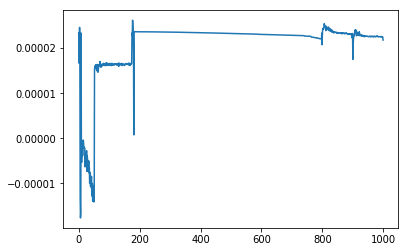

In [43]:
r, fs, subfs = 1, 0, 3
filn = glob.glob("data/results" + str(r) + "/fs_" + str(fs) + "_subfs_" + str(subfs) + "_*.npz")[0]
print filn
model_file = np.load(filn)
model = model_file['model']
#keep a list of the 1000 features kept
model_feat_scores = model[0].named_steps['feature_selection'].scores_
model_pca_var = model[0].named_steps['decomp'].explained_variance_
model_pca_var_rat = model[0].named_steps['decomp'].explained_variance_ratio_
model_pca_covar = model[0].named_steps['decomp'].get_covariance()
model_pca_mean = model[0].named_steps['decomp'].mean_
n_comp = model[0].named_steps['decomp'].n_components_
comp = model[0].named_steps['decomp'].components_
print len(model_pca_var), model_pca_var
print len(model_pca_var_rat), model_pca_var_rat
print model_pca_covar.shape, model_pca_covar
# plt.imshow(model_pca_covar)
print len(model_pca_mean), model_pca_mean
print n_comp
print comp.shape, comp
nfeat = 1000
feat_importance = np.zeros(nfeat)
for nc in range(len(comp)):
    feat_importance += comp[nc]*model_pca_var_rat[nc]
#     plt.plot(range(1000),comp[nc]*model_pca_var_rat[nc])
plt.plot(range(nfeat),feat_importance/nfeat)
print feat_importance*nfeat
sort_feat_imp_ind = np.array(feat_importance).argsort()[:][::-1]
print np.array(featnames)[sort_feat_imp_ind]